# Artificial Neural Networks and Deep Learning - Homework 2

| Overfitters del test set    | PoliMi ID |
|:----------------------------|:---------:|
|Pertino Paolo                | 10729600  |
|Sandri Alberto               | 10698469  |
|Simionato Enrico             | 10698193  |

In the second homework of the Artificial Neural Networks and Deep Learning course, a time series forecasting is proposed. The goal is to predict future samples of the input time series.

## 0. Preliminary operations

In the following section some preliminary operations in order to setup the environment correctly are performed.

### 0.1 Connect to Drive

In [ ]:
try:
    from google.colab import drive
    print("Code running on Google Colab... Conncecting to Google Drive...")
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 2
except:
    print("The code is not running on Google Colab...")

Code running on Google Colab... Conncecting to Google Drive...
Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 2


### 0.2 Download and import Libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install pandas
!pip install scipy
!pip install Cython
!pip install opencv-python
!pip install -U keras_cv
!pip install imbalanced-learn
!pip install lime

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
import warnings
import logging
import random
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

random.seed(seed)

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
np.random.seed(seed)

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet_v2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.utils import resample
from IPython.display import Image
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
#from lime import lime_image
from skimage.segmentation import mark_boundaries

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

path_to_models='models/'

2.14.0
Num GPUs Available: 0


## 1. Dataset inspection

In this section the content of the dataset is inspected and the images are prepared for later analysis.

### 1.1 Loading the data

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

In [ ]:
categories.shape, training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

In [ ]:
valid_periods[0]

array([2325, 2776])

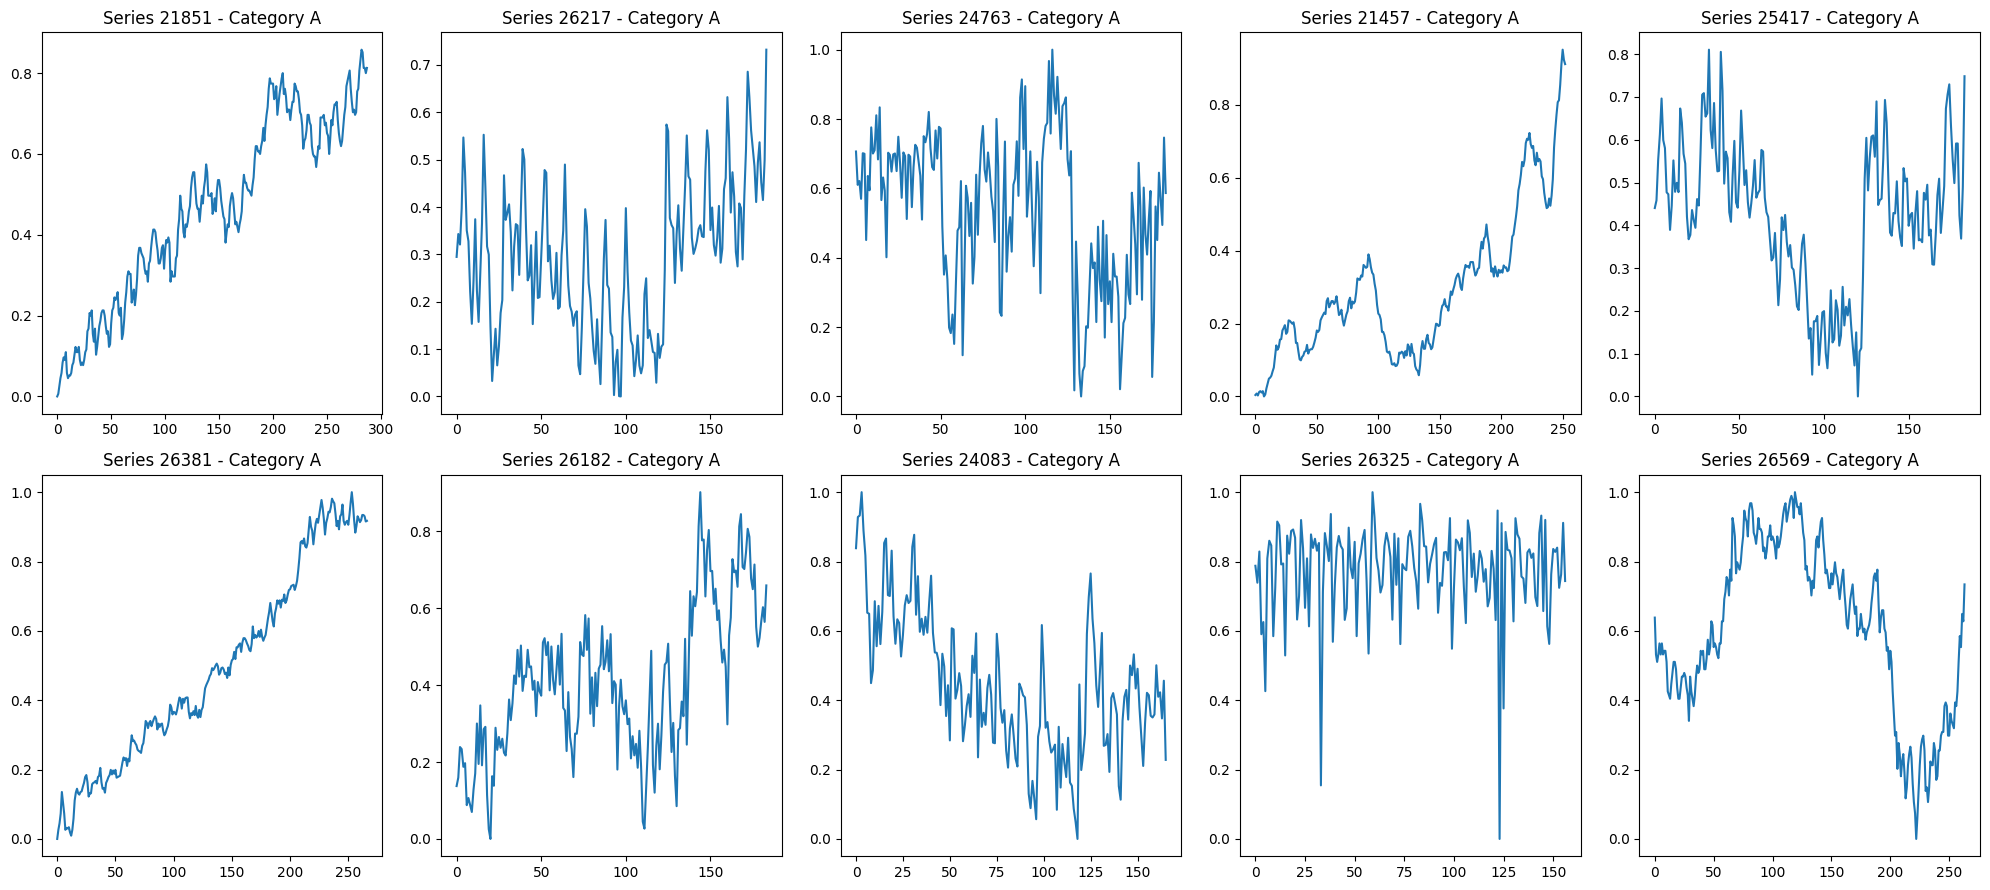

In [ ]:
num_series = 10

fig, axes = plt.subplots(2, num_series // 2, figsize=(20, 9))
for i in range(num_series):
    ax = axes[i % 2, i % num_series // 2]
    #index_shown = np.random.randint(0, categories ==.shape[0])
    index_shown = np.random.choice(np.where(categories == 'A')[0])
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]])
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

In [ ]:
np.argmin(valid_periods[:,1]-valid_periods[:,0])

47852

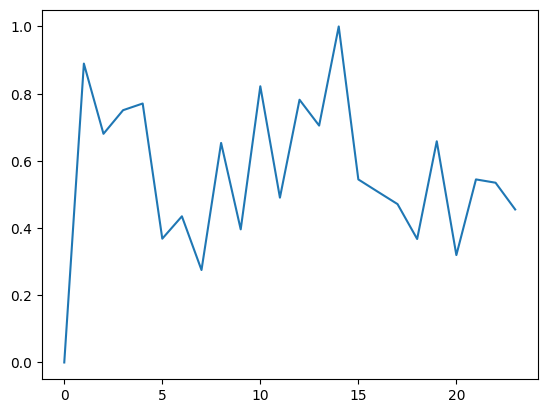

In [ ]:
index = 47852

plt.plot(training_data[index, valid_periods[index][0]:valid_periods[index][1]])

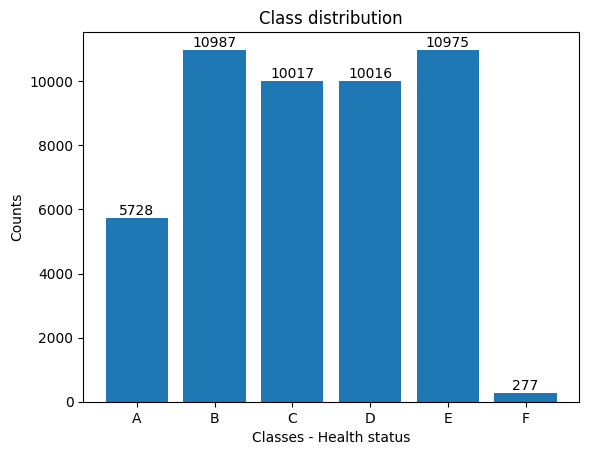

In [ ]:
# Defining the counts
counts = [sum(categories=='A'), sum(categories=='B'), sum(categories=='C'), sum(categories=='D'), sum(categories=='E'), sum(categories=='F')]

# Define labels
labels = ['A', 'B', 'C', 'D', 'E', 'F']

# Define colors for the bars
#colors = ['lightgreen', 'salmon']

# Create the barplot
plt.bar(labels, counts)

# Add axes labels
plt.xlabel('Classes - Health status')
plt.ylabel('Counts')

# Add title
plt.title('Class distribution')

# Add counts on top of the bars
for i, value in enumerate(counts):
  plt.text(labels[i], value, str(value), ha='center', va='bottom')

# Plot
plt.show()

In [ ]:
# Combine the image data and labels into a single array
combined_data = np.c_[training_data, categories]

# Convert the combined data to a Pandas DataFrame
df = pd.DataFrame(training_data)

# Use Pandas to drop duplicates based on all columns
df_no_duplicates = df.drop_duplicates()

# Extract the image data and labels from the DataFrame
unique_series_data = df_no_duplicates.iloc[:,:-1].values
unique_series_data = unique_series_data.astype(float)
unique_categories = df_no_duplicates.iloc[:, -1].values

# Now, unique_image_data and unique_labels contain the dataset without duplicates
print("Original dataset shape:", training_data.shape, categories.shape)
print("Dataset shape after removing duplicates:", unique_series_data.shape, unique_categories.shape)

Original dataset shape: (48000, 2776) (48000,)
Dataset shape after removing duplicates: (47974, 2775) (47974,)


In [ ]:
duplicates = df.duplicated()

In [ ]:
duplicates[:20].values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [ ]:
dup_idxs = np.where(duplicates == True)[0]
dup_idxs

array([ 2979,  6198, 17126, 17127, 27618, 34425, 34474, 34505, 34568,
       36034, 36082, 36792, 37054, 42190, 42284, 42996, 43018, 43059,
       43085, 43787, 44762, 45599, 46235, 46289, 46338, 46564])

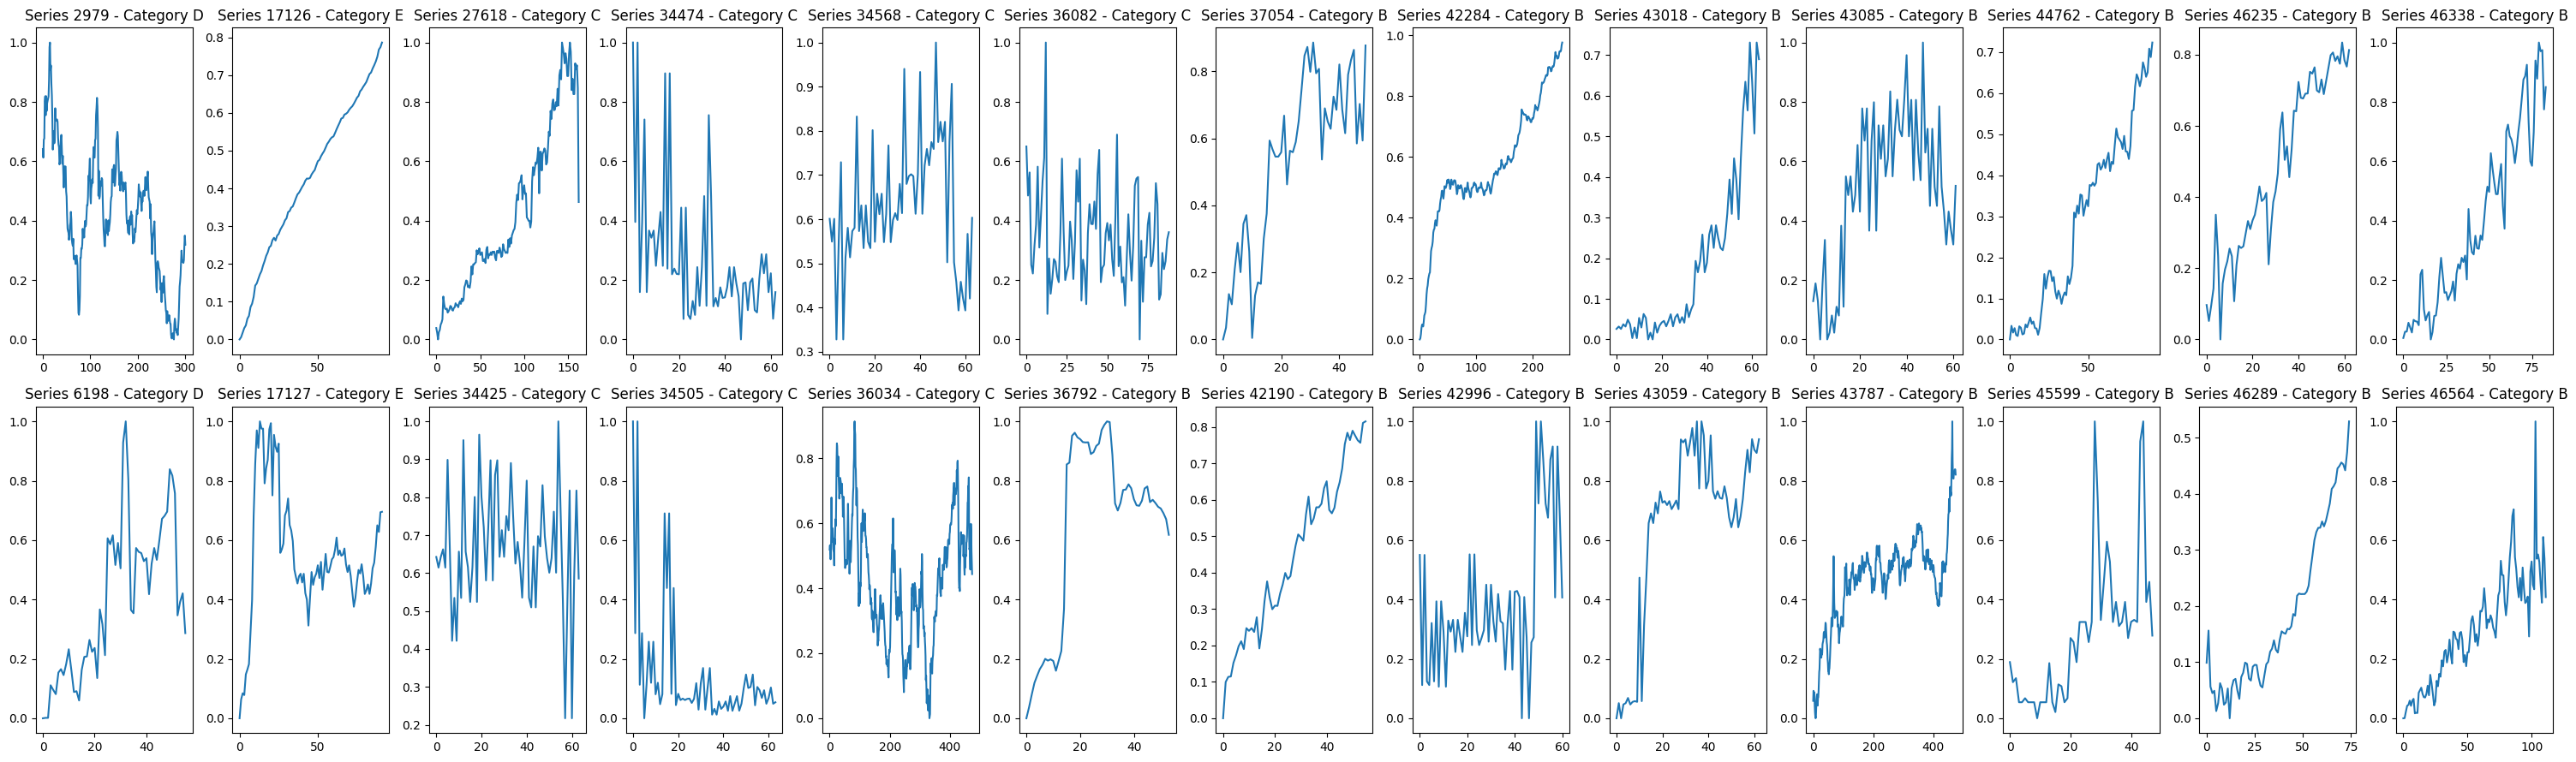

In [ ]:
num_series = len(dup_idxs)

fig, axes = plt.subplots(2, num_series // 2, figsize=(30, 9))
for i, index_shown in enumerate(dup_idxs):
    ax = axes[i % 2, i % num_series // 2]
    #index_shown = np.random.randint(0, categories ==.shape[0])
    ax.plot(training_data[index_shown, valid_periods[index_shown][0]:valid_periods[index_shown][1]])
    ax.set_title(f"Series {index_shown} - Category {categories[index_shown]}")
plt.tight_layout()
plt.show()

In [ ]:
training_data_no_duplicates = training_data[not duplicates.values]

In [ ]:
invert = lambda x: not(x)

In [ ]:
duplicates = np.invert(duplicates.values)

In [ ]:
training_data_no_duplicates = training_data[duplicates]


In [ ]:
categories = categories[duplicates]
training_data = training_data[duplicates]
valid_periods = valid_periods[duplicates]

In [ ]:
np.save('data/categories', categories, allow_pickle=True)
np.save('data/training_data', training_data, allow_pickle=True)
np.save('data/valid_periods', valid_periods, allow_pickle=True)

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
training_data = np.load('data/training_data.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)

categories.shape, training_data.shape, valid_periods.shape

((47974,), (47974, 2776), (47974, 2))

In [ ]:
data = np.load('data/public_data.npz', allow_pickle=True)

images = data.get('data')
labels = data.get('labels')

images.shape, labels.shape

((5200, 96, 96, 3), (5200,))

### 1.2 Outliers removal

Let's remove the outliers we have just found and all their copies in the dataset (if any).

In [ ]:
trololo = images[1903]
shrek = images[4282]

trolls = []
for i in tqdm(range(len(images))):
  if np.array_equiv(images[i], trololo) or np.array_equiv(images[i], shrek):
    trolls.append(i)

print(f"In the dataset there are {len(trolls)} outliers.")

 66%|██████▌   | 3439/5200 [00:00<00:00, 4070.44it/s]

100%|██████████| 5200/5200 [00:01<00:00, 3873.89it/s]

In the dataset there are 196 outliers.


In [ ]:
# Deleting the trolls
images_no_outliers = np.delete(images, trolls, axis = 0)
labels_no_outliers = np.delete(labels, trolls, axis = 0)

images_no_outliers.shape, labels_no_outliers.shape

((5004, 96, 96, 3), (5004,))

Finally let's check if there are duplicates and eventually remove them.

In [ ]:
# Combine the image data and labels into a single array
combined_data = np.c_[images_no_outliers.reshape((images_no_outliers.shape[0], -1)), labels_no_outliers]

# Convert the combined data to a Pandas DataFrame
df = pd.DataFrame(combined_data)

# Use Pandas to drop duplicates based on all columns
df_no_duplicates = df.drop_duplicates()

# Extract the image data and labels from the DataFrame
unique_image_data = df_no_duplicates.iloc[:, :-1].values.reshape((df_no_duplicates.shape[0], 96, 96, 3))
unique_image_data = unique_image_data.astype(float)
unique_labels = df_no_duplicates.iloc[:, -1].values

# Now, unique_image_data and unique_labels contain the dataset without duplicates
print("Original dataset shape:", images_no_outliers.shape, labels_no_outliers.shape)
print("Dataset shape after removing duplicates:", unique_image_data.shape, unique_labels.shape)

Original dataset shape: (5004, 96, 96, 3) (5004,)
Dataset shape after removing duplicates: (4850, 96, 96, 3) (4850,)


### 1.3 Storing and loading the dataset without outliers

In [ ]:
# Storing the dataset without outliers
np.save('data/public_data_no_outliers', unique_image_data, allow_pickle=True)
np.save('data/public_labels_no_outliers', unique_labels, allow_pickle=True)

In [ ]:
images_no_outliers = np.load('data/public_data_no_outliers.npy', allow_pickle=True)
labels_no_outliers = np.load('data/public_labels_no_outliers.npy', allow_pickle=True)

images_no_outliers.shape, labels_no_outliers.shape

((4850, 96, 96, 3), (4850,))

### 1.4 Plots and statistics

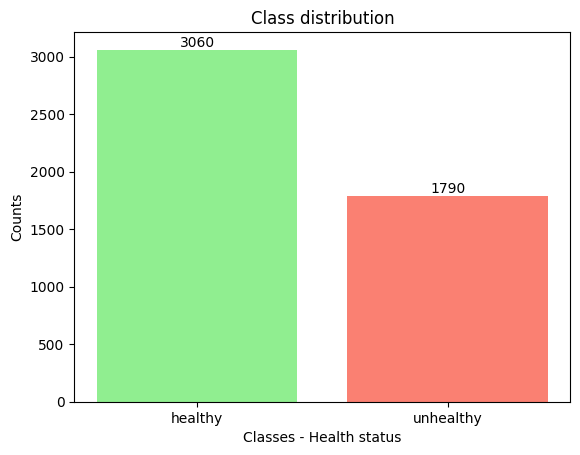

In [ ]:
# Defining the counts
counts = [sum(labels_no_outliers=='healthy'), sum(labels_no_outliers=='unhealthy')]

# Define labels
labels = ['healthy', 'unhealthy']

# Define colors for the bars
colors = ['lightgreen', 'salmon']

# Create the barplot
plt.bar(labels, counts, color=colors)

# Add axes labels
plt.xlabel('Classes - Health status')
plt.ylabel('Counts')

# Add title
plt.title('Class distribution')

# Add counts on top of the bars
for i, value in enumerate(counts):
  plt.text(labels[i], value, str(value), ha='center', va='bottom')

# Plot
plt.show()

In [ ]:
print(f"""
  In the healthy class there are {counts[0]} samples which cover the {(counts[0] / (counts[0] + counts[1]))*100:.2f}% of the whole dataset.
  In the unhealthy class there are {counts[1]} samples which cover the {(counts[1] / (counts[0] + counts[1]))*100:.2f}% of the whole dataset.
""")


  In the healthy class there are 3060 samples which cover the 63.09% of the whole dataset.
  In the unhealthy class there are 1790 samples which cover the 36.91% of the whole dataset.



The dataset is a little bit unbalanced towards the healthy class since there are 3101 samples in this class against 1903 of the other. However we think that this is not a big problem since the difference is not so big. To deal with the problem we prefer using sample weighting during training and eventually modifying the threshold to discriminate the 2 classes by analyzing the `ROC` curve.

### 1.5 Pre-processing

In [ ]:
# Convert labels to one-hot encoding format
y = np.zeros((labels_no_outliers.shape[0], 2))
y[labels_no_outliers=='healthy', 0] = 1.
y[labels_no_outliers=='unhealthy', 1] = 1.

# Setting the input dataset to split
X = (images_no_outliers / 255).astype(np.float32)

# Defining the number of samples in the test set and in the validation set
validation_size = 500
test_size = 500

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3850, 96, 96, 3), y_train shape: (3850, 2)
X_val shape: (500, 96, 96, 3), y_val shape: (500, 2)
X_test shape: (500, 96, 96, 3), y_test shape: (500, 2)


In [ ]:
from tqdm import tqdm

def create_dataset(original_data, intervals, window, stride, telescope):
  """
  Splits the series in the dataset creating many windows from the same time
  series depending on the given parameters.

  DOC TODO

  """

  new_samples = []
  new_targets = []

  for sample_idx, sample in enumerate(tqdm(original_data, desc="Creating Dataset")):
    series = sample[int(intervals[sample_idx,0]):int(intervals[sample_idx,1])]
    length_sample = series.shape[0]

    # Calculating the number of samples in the new dataset
    if length_sample > window:
      n_new_samples = ((length_sample - window) // stride) + 2
    else:
      n_new_samples = 1

    # Initializing arrays for features and targets
    features = np.zeros((n_new_samples, window))
    targets = np.zeros((n_new_samples, telescope))

    # Creating the new dataset
    for i in range(n_new_samples):
      start = length_sample - i * stride - window - telescope
      end = start + window

      if start >= 0:
        features[i, :] = series[start:end]
        #print(features[i, :])
        targets[i, :] = series[end : end + telescope]
      else:
        features[i, :] = np.pad(series[0:end], ((window - end, 0)), 'constant', constant_values=0)
        #print(features[i, :])
        targets[i, :] = sample[end : end + telescope]

    for element in features:
      new_samples.append(element)
    for element in targets:
      new_targets.append(element)

  return np.array(new_samples), np.array(new_targets)

## 2. Models

### 2.1 Utility functions

In [ ]:
def predict_test_time_augmented(model : tf.keras.Model, input : np.array, tta_augmentation, tta_range : int = 20, preprocessing_function = None):
  """
  Returns the predictions of the model applying test-time augmentation.

  Parameters:
      model (tf.keras.Model): model to use to predict the labels.
      input (np.array): input images of which the prediction has to be performed.
      tta_augmentation (tensorflow.keras.Sequential): transformation to be
        applied to the images in the test-time augmentation.
      tta_range (int): number of augmented images to use for giving the
        prediction to each single sample.
      preprocessing_function (funct): preprocessing function to be applied to
        the images before giving them to the model.
  Returns:
      tensorflow.Tensor: predictions of the model applying test-time augmentation.
  """

  predictions = []

  for i in range(tta_range):
      preds = model.predict(tta_augmentation(input) if preprocessing_function is None else preprocessing_function(tta_augmentation(input)))
      predictions.append(preds)

  predictions = np.mean(predictions, axis=0)

  return predictions


In [ ]:
def plot_confusion_matrix(input : np.ndarray,
                          y_test : np.ndarray,
                          threshold : int = 0.5,
                          model_to_test : tf.keras.Model = None,
                          model_name : str = None,
                          one_class : bool = False,
                          preprocessing_tta = None,
                          tta_range : int = 10,
                          preprocessing_function = None) -> None:
  '''
    Plots the confusion matrix and displays classification metrics for the
    specified model on the specified test data.

    The function first checks whether a model or a model name is provided for
    evaluation. If neither is provided, it will print an error message and
    return without further execution.

    If a model is provided (model_to_test is not None), the function uses it for
    evaluation. If only a model name is provided, the function loads the saved
    model with that name using tf.keras.models.load_model.

    It then predicts labels for the test data using the model and calculates
    the confusion matrix, as well as various classification metrics, including
    accuracy, precision, recall, and F1-score.

    The confusion matrix is plotted using a heatmap, and the classification
    metrics are displayed in the console.

    Parameters:
      input (numpy.ndarray): Input data for testing.
      y_test (numpy.ndarray): Ground truth labels for the test data.
      model_to_test (tf.keras.Model, optional): The model to evaluate. If
        provided, this model will be used for evaluation.
      model_name (str, optional): The name of a saved Keras model to load for
      evaluation. If provided, this model will be loaded and used for
        evaluation.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.
      tta_range (int): number of augmented images to use for giving the
        prediction to each single sample.
      preprocessing_tta (tf.keras.Sequential): transformation to be
        applied to the images in the test-time augmentation.
      preprocessing_function (function): Processing function to apply to the
        input data before giving them as input to the network.

    Returns:
      None
  '''

  if model_to_test is None and model_name is None:
    print("You have to specify either a model name or pass directly the model you want to evaluate.")
    return

  if model_to_test is not None:
    # Loading the model
    model = model_to_test
  else:
    model = tf.keras.models.load_model(model_name)

  # Predict labels for the entire test set
  if preprocessing_tta is None:
    predictions_logits = model.predict(input if preprocessing_function is None else preprocessing_function(input), verbose=0)
  else:
    predictions_logits = predict_test_time_augmented(model, input, preprocessing_tta, tta_range=tta_range, preprocessing_function=preprocessing_function)

  if one_class:
    predicted_label = np.array([1. if prediction >= threshold else 0. for prediction in predictions_logits])
    true_label = y_test
  else:
    predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])
    true_label = np.argmax(y_test, axis=-1)
    predicted_label = np.argmax(predictions, axis=-1)

  # Compute the confusion
  cm = confusion_matrix(true_label, predicted_label)

  # Compute classification metrics
  accuracy = accuracy_score(true_label, predicted_label)
  precision = precision_score(true_label, predicted_label)
  recall = recall_score(true_label, predicted_label)
  f1 = f1_score(true_label, predicted_label)

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  if model_name:
    del model

In [ ]:
def plot_roc_curve(model : tf.keras.Model, X : np.ndarray, y : np.ndarray, plot_diagrams : bool = True) -> float:
  '''
    Plots Receiver Operating Characteristic (ROC) curves for different threshold
    values and identifies the best threshold based on the highest AUC score.

    This function calculates and plots ROC curves for a given model's predictions
    on the input data, considering various threshold values (from 0.05 to 1 with
    step 0.05). It also identifies the best threshold based on the highest Area
    Under the Curve (AUC) score.

    Parameters:
        model (tf.keras.Model): The machine learning model for which the ROC
                                curves are plotted.
        X (numpy.ndarray): Input data used for model predictions.
        y (numpy.ndarray): Ground truth labels for the input data.

    Returns:
        float: the best threshold retrieved by the aalysis of the AUC score.

  '''

  roc_curves = []
  predictions_logits = model.predict(X)

  thresholds = np.arange(0.05, 1.05, 0.05)
  best_auc = 0
  best_threshold = 0

  for threshold in thresholds:
      # Convert predictions using the current threshold
      predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])

      # Calculate the ROC curve
      fpr, tpr, _ = roc_curve(y.argmax(axis=-1), predictions.argmax(axis=-1))

      roc_auc = auc(fpr, tpr)
      # Append the ROC curve data to the list
      roc_curves.append((fpr, tpr, threshold))

      if roc_auc > best_auc:
        best_auc = roc_auc
        best_threshold = threshold

  # Plot ROC curves
  if plot_diagrams:
    plt.figure(figsize=(8, 6))
    for fpr, tpr, threshold in roc_curves:
        plt.plot(fpr, tpr, label=f'Threshold: {threshold}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot the diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    print(f"The best threshold is {best_threshold} with AUC score of {best_auc}")
  return best_threshold

In [ ]:
def plot_training(history):
  '''
    Plots training and validation performance metrics, including loss and
    accuracy, and highlights the epoch with the highest validation accuracy.

    This function takes a history dictionary that contains training and
    validation metrics recorded during model training and visualizes the
    training and validation performance over epochs. It also highlights
    the epoch with the highest validation accuracy.

    Parameters:
        history (dict): A dictionary containing training and validation metrics
        (e.g., loss, accuracy) recorded during model training.

    Returns:
        None
  '''

  # Find the epoch with the highest validation accuracy
  best_epoch = np.argmax(history['val_accuracy'])

  # Plot training and validation performance metrics
  plt.figure(figsize=(20, 5))

  # Plot training and validation loss
  plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.legend(loc='upper left')
  plt.title('Binary Crossentropy')
  plt.grid(alpha=0.3)

  plt.figure(figsize=(20, 5))

  # Plot training and validation accuracy, highlighting the best epoch
  plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=0.3)

  plt.show()

In [ ]:
def k_fold_cross_validation(
    train_data : np.ndarray,
    train_labels : np.ndarray,
    model_builder,
    model_builder_parameters : tuple = (),
    early_stopping_patience : int = 0,
    epochs : int = 200,
    batch_size : int = 32,
    model_callbacks : list = None,
    num_folds : int = 5,
    verbose = 0,
    seed : int = 42
  ) -> dict:
  '''
  Perform K-fold cross-validation for training and evaluating the specified
  model class.

  This function performs K-fold cross-validation by splitting the training
  data into multiple folds, training a model on each fold, and evaluating its
  performance on the validation data. It returns a dictionary with information
  about the training process for each fold.

  Parameters:
      train_data (numpy.ndarray): The training data used for cross-validation.
      train_labels (numpy.ndarray): The corresponding ground truth labels for the training data.
      model_builder (function): A function that builds and returns the model class of interest. This function should take model parameters as input.
      model_builder_parameters (tuple, optional): Additional parameters to be passed to the model_builder function.
      early_stopping_patience (int, optional): The number of epochs to wait for improvement during early stopping. Set this number equal to the one you have chosen for the early stopping.
      epochs (int, optional): The maximum number of epochs for training each fold.
      model_callbacks (list, optional): List of Keras callbacks to be applied during training.
      num_folds (int, optional): The number of cross-validation folds.
      seed (int, optional): Random seed for controlling the randomness of cross-validation.

  Returns:
      dict: A dictionary containing the training histories, validation scores, best epochs for early stopping, and best prediction thresholds for each fold.

  '''

  # Initialize lists to store training histories, scores, and best epochs
  result = {}
  histories = []
  scores = []
  best_epochs = []
  best_prediction_thresholds = []

  # Create a KFold cross-validation object
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(train_data, np.argmax(train_labels, axis=-1))):

    print(f"Starting training on fold num: {fold_idx+1}")

    # Build a new dropout model for each fold
    k_model = model_builder(*model_builder_parameters)

    # Train the model on the training data for this fold
    history = k_model.fit(
      x = train_data[train_idx],
      y = train_labels[train_idx],
      validation_data=(train_data[valid_idx], train_labels[valid_idx]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = model_callbacks,
      verbose = verbose
    ).history

    # Evaluate the model on the validation data for this fold
    score = k_model.evaluate(train_data[valid_idx], train_labels[valid_idx], verbose=0)
    scores.append(score[1])

    # Calculate the best epoch for early stopping
    best_epoch = len(history['loss']) - early_stopping_patience - 1
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)

    # Store the best prediction threshold
    best_prediction_thresholds.append(
        plot_roc_curve(
            k_model,
            train_data[valid_idx],
            train_labels[valid_idx],
            plot_diagrams = False)
    )

    del k_model
    gc.collect()

  result.update({
      'histories' : histories,
      'scores' : scores,
      'best_epochs' : best_epochs,
      'best_thresholds' : best_prediction_thresholds
  })

  return result

In [ ]:
def k_fold_cross_validation_nested(
    train_data : np.ndarray,
    train_labels : np.ndarray,
    model_builder,
    early_stopping_patience : int = 0,
    epochs : int = 200,
    batch_size : int = 32,
    model_callbacks : list = None,
    num_folds : int = 5,
    verbose = 0,
    seed : int = 42,
    param_grid : dict = None,
    num_folds_inner : int = 3
  ) -> dict:
  '''
  Perform nested K-fold cross-validation for training and evaluating the specified
  model class and doing hyperparameters tuning.

  This function performs nested K-fold cross-validation by splitting the training
  data into multiple folds, performing for each fold another K-fold cross-validation
  for each combination of the hyperparameters, and evaluating its performance on
  the validation data. It returns a dictionary with information about the training
  process for each fold.

  Parameters:
      train_data (numpy.ndarray): The training data used for cross-validation.
      train_labels (numpy.ndarray): The corresponding ground truth labels for the training data.
      model_builder (function): A function that builds and returns the model class of interest. This function should take model parameters as input from the ones defined in param_grid.
      early_stopping_patience (int, optional): The number of epochs to wait for improvement during early stopping. Set this number equal to the one you have chosen for the early stopping.
      epochs (int, optional): The maximum number of epochs for training each fold.
      model_callbacks (list, optional): List of Keras callbacks to be applied during training.
      num_folds (int, optional): The number of outer cross-validation folds.
      seed (int, optional): Random seed for controlling the randomness of cross-validation.
      param_grid (dict, optional): Dictionary containing the hyperparams to evaluate.
      num_folds_inner (int, optional): The number of inner cross-validation folds.

  Returns:
      dict: A dictionary containing the average validation scores, average best epochs for early stopping for each combination of hyperparams for each fold.

  '''

  # Initialize lists to store training histories, scores, and best epochs
  result = {}
  scores_final = []
  best_epochs_final = []

  # Create a KFold cross-validation object
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

  # Get all possible combinations of values
  all_combinations = list(product(*param_grid.values()))

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(train_data, np.argmax(train_labels, axis=-1))):

    print(f"Starting on outer training on fold num: {fold_idx+1}")
    print("=======================================")

    # Create an inner loop for hyperparameter tuning (inner CV)
    kfold_inner = StratifiedKFold(n_splits=num_folds_inner, shuffle=True, random_state=seed)

    scores_avg = []
    best_epochs_avg = []

    # Print the combinations
    for combo in tqdm(all_combinations):
      print(f'\nEvaluating {dict(zip(param_grid.keys(), combo))} on outer fold num {fold_idx+1}\n')

      scores = []
      best_epochs = []

      for fold_idx_inner, (train_idx_inner, valid_idx_inner) in enumerate(kfold_inner.split(train_data[train_idx], np.argmax(train_labels[train_idx], axis=-1))):

        k_model = model_builder(*(tuple(combo)))

        # Train the model on the training data for this fold
        history = k_model.fit(
          x = train_data[train_idx_inner],
          y = train_labels[train_idx_inner],
          validation_data=(train_data[train_idx_inner], train_labels[train_idx_inner]),
          batch_size = batch_size,
          epochs = epochs,
          callbacks = model_callbacks,
          verbose = verbose
        ).history

        # Evaluate the model on the validation data for this fold
        score = k_model.evaluate(train_data[valid_idx_inner], train_labels[valid_idx_inner], verbose=0)
        scores.append(score[1])

        # Calculate the best epoch for early stopping
        best_epoch = len(history['loss']) - early_stopping_patience - 1
        best_epochs.append(best_epoch)

        del k_model
        gc.collect()

      scores_avg.append(np.mean(scores))
      best_epochs_avg.append(np.mean(best_epochs))
      print("\n=======================================")
      print(f"\nAverage score on fold num {fold_idx+1} for {dict(zip(param_grid.keys(), combo))} is {scores_avg[-1]}")
      print(f"\nAverage best epoch on fold num {fold_idx+1} for {dict(zip(param_grid.keys(), combo))} is {best_epochs_avg[-1]}\n")
      print("=======================================")

    scores_final.append(scores_avg)
    best_epochs_final.append(best_epochs_avg)

  result.update({
      'scores' : scores_final,
      'best_epochs' : best_epochs_final,
  })

  return result

In [ ]:
def undersample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform undersampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y undersampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  undersample = RandomUnderSampler()
  undersampled_X, undersampled_y  = undersample.fit_resample(reshaped_X , y)

  if not one_class:
    undersampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in undersampled_y])

  return undersampled_X.reshape(-1,96,96,3), undersampled_y

In [ ]:
def oversample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform oversampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y overrsampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  oversample = RandomOverSampler()
  oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

  if not one_class:
    oversampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in oversampled_y])

  return oversampled_X.reshape(-1,96,96,3), oversampled_y

In [ ]:
def bootstrap_samples(samples : np.ndarray, labels : np.ndarray, num_samples : int, num_bootstraps : int = 1, replace : bool = True, seed : int = 42):
  '''
  Generates a bootstrap sample from a dataset.

  This function generates a bootstrap sample from a dataset by randomly
  sampling from the dataset with replacement.

  Parameters:
      samples (numpy.ndarray): The dataset from which to generate the bootstrap sample.
      labels (numpy.ndarray): The corresponding ground truth labels for the dataset.
      num_samples (int, optional): The number of samples to include in the bootstrap sample. Defaults to 1.
      num_bootstraps (int, optional): The number of bootstrap dataset to generate. Defaults to 1.
      replace (bool, optional): If true, sampling with replacement is performed. Defaults to True.
      seed (int, optional): Random seed for controlling the randomness of sampling.

  Returns:
      numpy.ndarray: The generated bootstrap sample.
  '''
  bootstrap_dataset = []
  for i in range(num_bootstraps):
    X_bootstrap, y_bootstrap = resample(samples, labels, replace=replace, n_samples=num_samples, stratify=np.argmax(labels, axis=1), random_state=seed+i)
    bootstrap_dataset.append((X_bootstrap, y_bootstrap))

  return bootstrap_dataset

In [ ]:
def get_sample_weights(y : np.ndarray, weight_positive : float, weight_negative : float) -> np.ndarray:
  """
  Generate the array of weights for each one of the samples related to the given
  labels.

  Parameter:
      y (np.ndarray): Array of the labels of the considered samples one-hot encoded,
        so with shape (#samples, 2).
      weight_positive (float): Weight to give to positive samples.
      weight_negative (float): Weight to give to negative samples.

  Returns:
      np.ndarray: array of the sample weights.
  """

  weights = np.zeros(y.shape[0])
  weights += weight_negative * y[:,0]
  weights += weight_positive * y[:,1]

  return weights